# Having fun with py-starbound

## Imports:

In [2]:
import glob
import starbound as sb

import pandas as pd
import seaborn as sns

## Setting the file source

In [3]:
import configparser

config: configparser.ConfigParser = configparser.ConfigParser()
config.read("config.ini")

starbound_src_folder: str = config.get('src', 'folder')
player_folder: str = f"{starbound_src_folder}/storage/player"
universe_folder: str = f"{starbound_src_folder}/storage/universe"

## Working with character files:

We first load the characters into an *global* array to not need to redo the file operations every time.

In [4]:
players: list[sb.VersionedJSON] = []
player_files = list(glob.iglob(f"{player_folder}/*.player", recursive=True))

for file in player_files:
	with open(file, 'r+b') as fh:
		player: sb.VersionedJSON = sb.read_sbvj01(fh)
		players.append(player)

### Now a very simple operation to print a specific string to get the characters:

In [5]:
from utils import playtime_to_string

for player in players:
	name: str = player.data['identity']['name']
	gender: str = player.data['identity']['gender']
	species: str = player.data['identity']['species']
	playtime = playtime_to_string(player.data['log']['playTime'])
	print(f'You got a {gender:>6} {species.title():>7} with the name: {name:>15} that you played for: {playtime}')

You got a female Novakid with the name:            Jane that you played for: 2 hours, 9 minutes, 9 seconds, 7749200 milliseconds
You got a female   Human with the name:          Marisa that you played for: 0 milliseconds
You got a   male   Avian with the name:          Noxoch that you played for: 1 hour, 25 minutes, 9 seconds, 5109384 milliseconds
You got a female    Apex with the name:         Myranda that you played for: 3 hours, 2 minutes, 19 seconds, 10939051 milliseconds
You got a female  Hylotl with the name:   Shrine Maiden that you played for: 4 hours, 15 minutes, 25 seconds, 15325384 milliseconds
You got a female   Human with the name:           Lilly that you played for: 152 hours, 44 minutes, 17 seconds, 549857529 milliseconds
You got a   male  Hylotl with the name:          Noboru that you played for: 65 hours, 55 minutes, 17 seconds, 237317362 milliseconds
You got a female  Floran with the name:              Ru that you played for: 1 hour, 25 minutes, 18 seconds, 5118884 m

### Dumping the JSON Data into a json file:

In [6]:
import json

for player in players:
	name: str = player.data['identity']['name']
	with open(f'characters/{name}.json', 'w', encoding='utf-8') as f:
		json.dump(player.data, f, ensure_ascii=False, indent=4)

### working with that statistics data

In [17]:
with open(f'{player_folder}/statistics', 'r+b') as fh:
	stats = sb.read_sbvj01(fh)
	# print(stats.data["stats"]["item.category.block"])
	blocks = stats.data["stats"]["item.category.block"]["value"]
	print(f'You still got {10000000 - blocks} to go!')
	# with open('stats.json', 'w', encoding='utf-8') as f:
	# 	json.dump(stats.data, f, ensure_ascii=False, indent=4)

You still got -30199 to go!


## Working with world files:

We first load the worlds into an *global* array to not need to redo the file operations every time.

In [ ]:
import mmap

worlds: list[sb.World] = []

world_files = list(glob.iglob(f"{universe_folder}/*_*_*.world", recursive=True))
for file in world_files:
	with open(file, 'r+b') as fh:
		mm: mmap = mmap.mmap(fh.fileno(), 0, access=mmap.ACCESS_READ)
		world: sb.World = sb.World(mm)
		world.read_metadata()
		worlds.append(world)

### Printing all the important world details

In [ ]:
from utils import strip_colors

for world in worlds:
	print(f'World Name: {strip_colors(world.info.name)}')
	print(f'World size: {world.width}×{world.height}')
	print(f'World Description: {world.info.description}')
	print(80 * '-')

World Name: Sadr Delta IV
World size: 6000×3000
World Description: Tier 2 Planet
--------------------------------------------------------------------------------
World Name: Acubens Tide I
World size: 3000×2000
World Description: Tier 1 Planet
--------------------------------------------------------------------------------
World Name: Castor Traverse V
World size: 4000×3000
World Description: Tier 2 Planet
--------------------------------------------------------------------------------
World Name: Castor Traverse I
World size: 4000×3000
World Description: Tier 2 Planet
--------------------------------------------------------------------------------
World Name: Castor Traverse II
World size: 4000×3000
World Description: Tier 2 Planet
--------------------------------------------------------------------------------
World Name: Castor Traverse III
World size: 3000×2000
World Description: Tier 1 Planet
--------------------------------------------------------------------------------
World Na

### Getting the Amount of dungeons

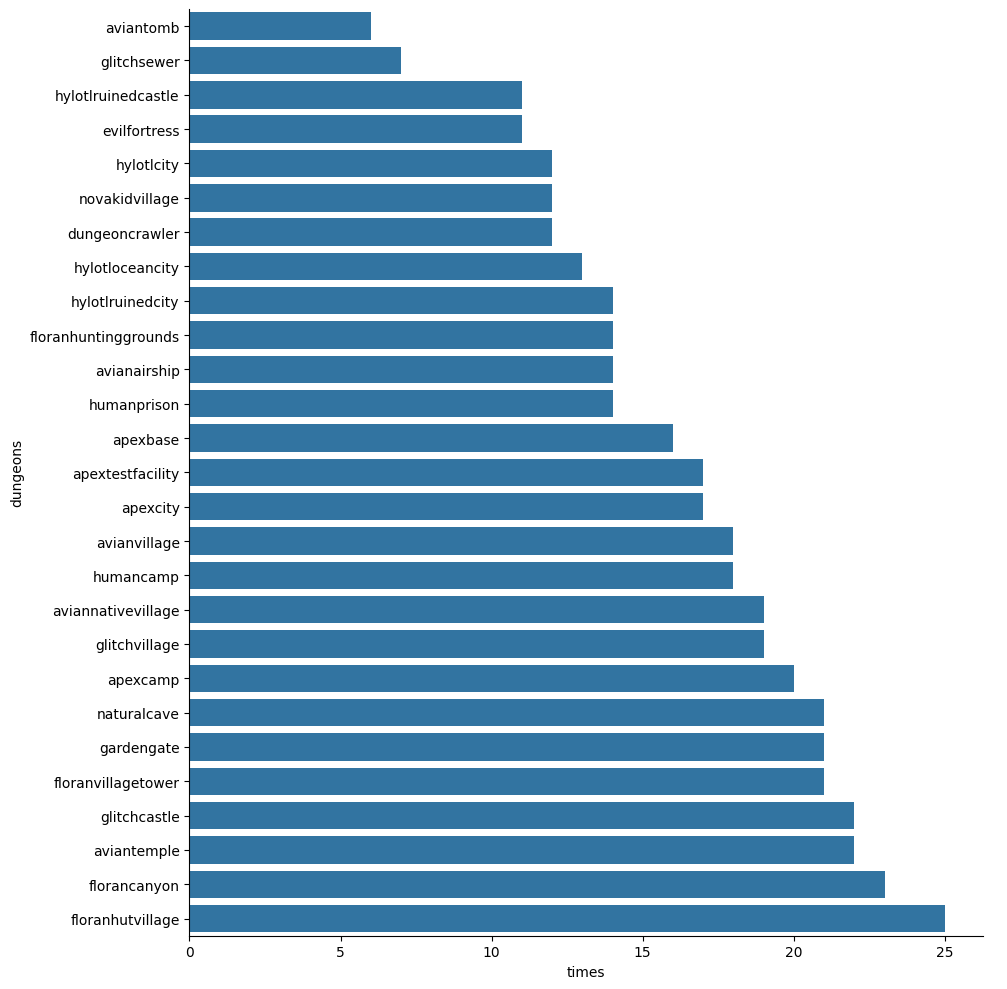

In [ ]:
known_dungeons: dict[str, int] = {}

for world in worlds:
	dungeons: list[str] = world.info.dungeons
	for dungeon in dungeons:
		if dungeon in known_dungeons:
			known_dungeons[dungeon] = known_dungeons[dungeon] + 1
		else:
			known_dungeons[dungeon] = 1

dungeons = pd.Series(data=known_dungeons).explode().reset_index(name="times").rename(columns={"index": "dungeons"}).sort_values("times")

sns.catplot(
	data=dungeons,
	kind="bar",
	x="times",
	y="dungeons",
	height=10
)

### Getting the Amount of biomes

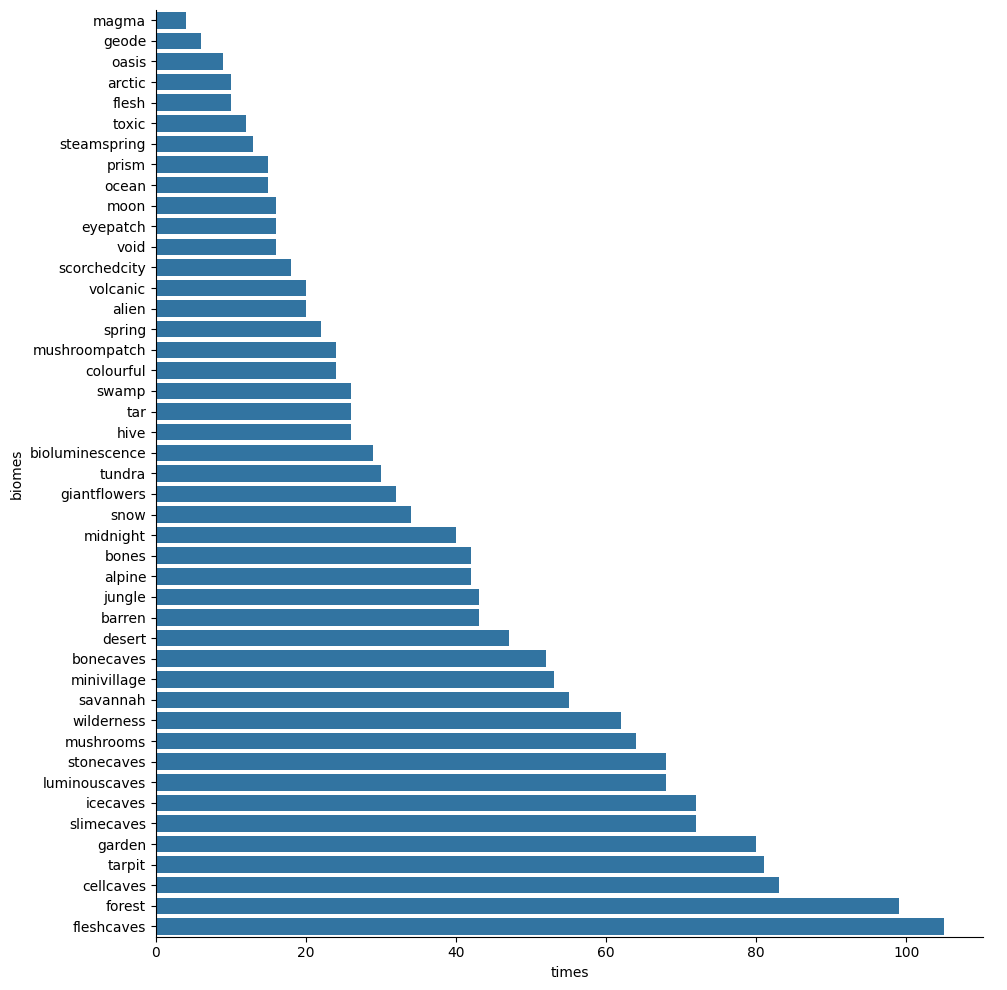

In [ ]:

known_biomes: dict[str, int]  = {}

for world in worlds:
	biomes: list[str] = world.info.biomes
	for biome in biomes:
		if "underground" in biome or "asteroids" in biome or "atmosphere" in biome or "core" in biome or "oceanfloor" in biome or "rust" in biome:
			continue
		if biome in known_biomes:
			known_biomes[biome] = known_biomes[biome] + 1
		else:
			known_biomes[biome] = 1

biomes = pd.Series(data=known_biomes).explode().reset_index(name="times").rename(columns={"index": "biomes"}).sort_values("times")

sns.catplot(
	data=biomes,
	kind="bar",
	x="times",
	y="biomes",
	height=10
)

### Some world testing

In [ ]:
from utils import strip_planet_number, list_to_str
star_systems = {}

for world in worlds:
	star_name = strip_planet_number(world.info.name)
	if star_name in star_systems:
		star_systems[star_name].append(world.info.description)
	else:
		star_systems[star_name] = [world.info.description]

for (system, level) in star_systems.items():
	print(system, "has:", list_to_str(level, ", "))

Sadr Delta has: Tier 2 Planet
Acubens Tide has: Tier 1 Planet
Castor Traverse has: Tier 2 Planet, Tier 2 Planet, Tier 2 Planet, Tier 1 Planet, Bog Standard Moon, Tier 2 Planet, Bog Standard Moon, Bog Standard Moon
Umbracia Ridge has: Tier 5 Planet, Tier 5 Planet, Tier 5 Planet
Tegmine Delta has: Bog Standard Moon
Wonton Expanse has: Tier 4 Planet, Tier 2 Planet, Tier 4 Planet, Tier 4 Moon, Tier 4 Moon, Tier 2 Planet, Bog Standard Moon
Decimata Swarm has: Tier 2 Planet, Tier 3 Planet, Bog Standard Moon, Tier 3 Planet, Tier 3 Planet, Bog Standard Moon
Chronotias Wake has: Tier 5 Planet, Tier 5 Planet, Tier 5 Planet
Baomra Formation has: Tier 2 Planet, Tier 3 Planet, Tier 3 Planet, Tier 2 Moon, Tier 2 Moon, Bog Standard Moon
Dschubba Legion has: Tier 3 Planet, Barren Planet, Tier 3 Planet, Tier 2 Planet
Alvas Swarm has: Tier 5 Planet, Tier 5 Planet, Tier 4 Planet
Hydor Minoris has: Tier 6 Planet, Tier 6 Planet, Bog Standard Moon
Tessera Cluster has: Ancient Gateway, Tier 5 Planet, Tier 6 

### printing the names of where the biomes are and their location

In [ ]:
from utils import strip_colors

locations: dict[list[tuple[str, tuple[int, int]]]] = {}

for world in worlds:
	biomes: list[str] = world.info.biomes
	for biome in biomes:
		if "underground" in biome or "asteroids" in biome or "atmosphere" in biome or "core" in biome or "oceanfloor" in biome or "rust" in biome:
			continue
		if biome in locations:
			locations[biome].append((strip_colors(world.info.name), (world.info.coords[0], world.info.coords[1])))
		else:
			locations[biome] = [(strip_colors(world.info.name), (world.info.coords[0], world.info.coords[1]))]

print(locations)

{'garden': [('Sadr Delta IV', (-180432185, 246617208)), ('Acubens Tide I', (-187296542, 525215233)), ('Castor Traverse V', (-187296553, 525215238)), ('Castor Traverse II', (-187296553, 525215238)), ('Castor Traverse III', (-187296553, 525215238)), ('Castor Traverse IV', (-187296553, 525215238)), ('Umbracia Ridge III', (-187296560, 525215290)), ('Decimata Swarm II', (-187296580, 525215259)), ('Baomra Formation I', (-187296593, 525215245)), ('Baomra Formation II', (-187296593, 525215245)), ('Dschubba Legion V', (-187296604, 525215233)), ('Dschubba Legion II', (-187296604, 525215233)), ('Alvas Swarm I', (-187296645, 525215232)), ('Kyren Cluster IV - c', (-187296655, 525215214)), ('Zaurak Sigma I', (-196058339, 148774534)), ('Zaurak Sigma II', (-196058339, 148774534)), ('Alshain Strand III - a', (-196058343, 148774559)), ('Alpha Tiyuri Crest III', (-196058387, 148774544)), ('Indie Minoris V', (-196058403, 148774570)), ('Indie Minoris III', (-196058403, 148774570)), ('Sagittarii Nest IV - a

## Printing csv files to use in a spreadsheet program

### starting with the dungeon data

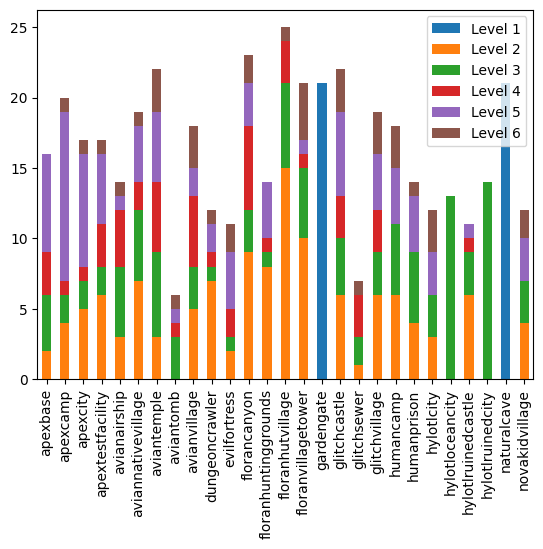

In [ ]:
known_dungeons: dict[str, tuple[str, dict[str, int]]] = {}

for world in worlds:
    dungeons: list[str] = world.info.dungeons
    tier: str = world.info.description.split()[1]
    if tier not in ["1", "2", "3", "4", "5", "6"]:
        continue
    for dungeon in dungeons:
        if dungeon in known_dungeons:
            if f"Level {tier}" in known_dungeons[dungeon]:
                known_dungeons[dungeon][f"Level {tier}"] = known_dungeons[dungeon][f"Level {tier}"] + 1
            else:
                known_dungeons[dungeon][f"Level {tier}"] =  1
        else:
            known_dungeons[dungeon] = {"Level 1": 0, "Level 2": 0, "Level 3": 0, "Level 4": 0, "Level 5": 0, "Level 6": 0}
            known_dungeons[dungeon][f"Level {tier}"] = 1

dungeons = pd.DataFrame.from_dict(data=known_dungeons).transpose().sort_index()

dungeons.plot(kind="bar", stacked=True)

dungeons = dungeons.reset_index().rename(columns={"index": "Dungeons"})
dungeons.to_csv('spreadsheet/dungeons.csv', index=False)

### further with the biome data

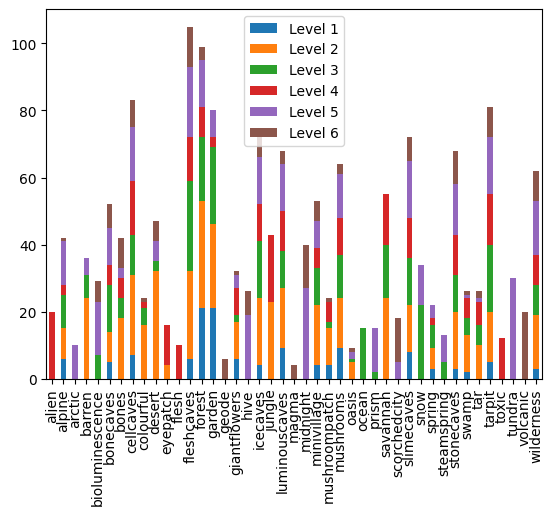

In [ ]:
known_biomes: dict[str, int]  = {}

for world in worlds:
    biomes: list[str] = world.info.biomes
    tier: str = world.info.description.split()[1]
    if tier not in ["1", "2", "3", "4", "5", "6"]:
        continue
    for biome in biomes:
        if "underground" in biome or "asteroids" in biome or "atmosphere" in biome or "core" in biome or "oceanfloor" in biome or "rust" in biome:
            continue
        if biome in known_biomes:
            if f"Level {tier}" in known_biomes[biome]:
                known_biomes[biome][f"Level {tier}"] = known_biomes[biome][f"Level {tier}"] + 1
            else:
                known_biomes[biome][f"Level {tier}"] =  1
        else:
            known_biomes[biome] = {"Level 1": 0, "Level 2": 0, "Level 3": 0, "Level 4": 0, "Level 5": 0, "Level 6": 0}
            known_biomes[biome][f"Level {tier}"] = 1

biomes = pd.DataFrame.from_dict(data=known_biomes).transpose().sort_index()

biomes.plot(kind="bar", stacked=True)

biomes = pd.DataFrame.from_dict(data=known_biomes).transpose().sort_index().reset_index().rename(columns={"index": "Biomes"})
biomes.to_csv('spreadsheet/biomes.csv', index=False)